In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.01MB/s]


In [ ]:
# Mini-batch DataLoader
batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Tüm indexleri al
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)

# %80 eğitim - %20 validasyon
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Sampler ayarları
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# DataLoader'lar
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)


In [ ]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)ll
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # 28 -> 14
        x = self.pool(self.relu(self.conv2(x)))  # 14 -> 7
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [ ]:
print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))

Train dataset size:  60000
Test dataset size:  10000


In [ ]:
num_batches = len(train_loader)
print(f"With batch_size={batch_size}, expected ≈{len(train_dataset)/batch_size:.1f} batches. Got {num_batches}.")

With batch_size=64, expected ≈937.5 batches. Got 750.


In [ ]:
for batch_idx, (imgs, labels) in enumerate(train_loader):
    print("  Batch", batch_idx, "‑ imgs:", imgs.shape, "labels:", labels.shape)
    break
else:
    print("Never entered the loop — loader is empty or raising inside.")

  Batch 0 ‑ imgs: torch.Size([64, 1, 28, 28]) labels: torch.Size([64])


In [ ]:
num_epochs = 5
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(num_epochs):
    # === EĞİTİM ===
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_losses.append(train_loss / train_total)
    train_accuracies.append(train_correct / train_total)

    # === VALIDASYON ===
    model.eval()
    valid_loss, valid_correct, valid_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            valid_correct += (preds == labels).sum().item()
            valid_total += labels.size(0)

    valid_losses.append(valid_loss / valid_total)
    valid_accuracies.append(valid_correct / valid_total)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.4f} - "
          f"Val Loss: {valid_losses[-1]:.4f}, Acc: {valid_accuracies[-1]:.4f}")


Epoch 1/5 - Train Loss: 0.1982, Acc: 0.9378 - Val Loss: 0.0644, Acc: 0.9802
Epoch 2/5 - Train Loss: 0.0546, Acc: 0.9825 - Val Loss: 0.0594, Acc: 0.9812
Epoch 3/5 - Train Loss: 0.0375, Acc: 0.9885 - Val Loss: 0.0423, Acc: 0.9871
Epoch 4/5 - Train Loss: 0.0277, Acc: 0.9911 - Val Loss: 0.0401, Acc: 0.9892
Epoch 5/5 - Train Loss: 0.0216, Acc: 0.9935 - Val Loss: 0.0423, Acc: 0.9878


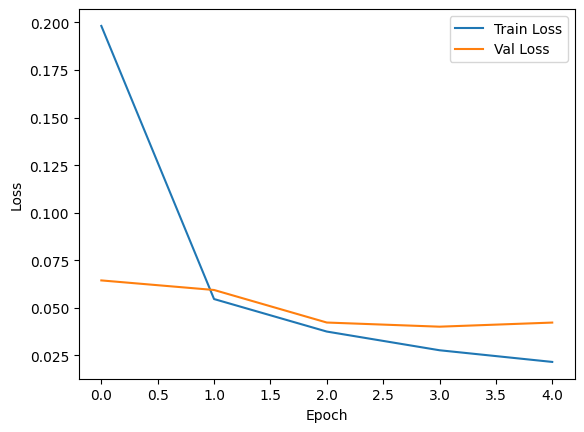

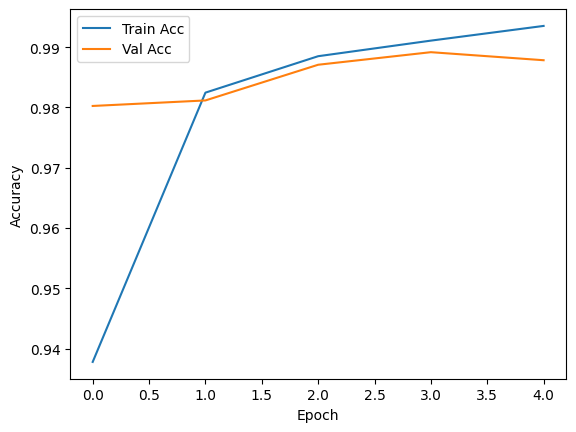

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(valid_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test setinde modelin başarısı
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Final Test Accuracy: 0.9894


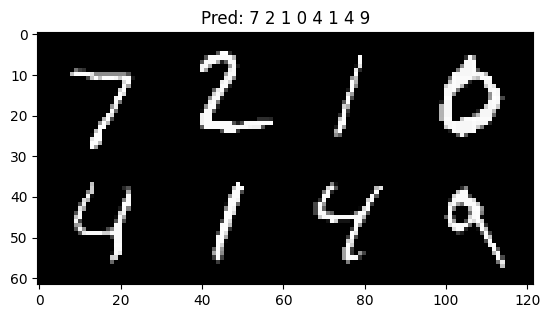

Misclassified in batch: [62]


In [ ]:
import torchvision

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = outputs.max(1)

# show first 8
grid = torchvision.utils.make_grid(images[:8].cpu(), nrow=4, padding=2)
plt.imshow(grid.permute(1,2,0).numpy())
plt.title("Pred: " + " ".join(str(p.item()) for p in preds[:8].cpu()))
plt.show()

# misclassified indices in this batch
wrong = (preds != labels)
print("Misclassified in batch:", torch.nonzero(wrong).flatten().tolist())

In [ ]:
import torch
import torch.nn.functional as F

model.eval()
images = images.to(device)

with torch.no_grad():
    logits = model(images)               # shape: [batch_size, 10]
    probs  = F.softmax(logits, dim=1)    # shape: [batch_size, 10], each row sums to 1

# Predicted class (highest probability) for each sample
preds = torch.argmax(probs, dim=1)       # shape: [batch_size]

# If you want the probability of that top prediction:
top_probs = probs[torch.arange(probs.size(0)), preds]

# Example: print for first 5 images
for i in range(5):
    print(f"Sample {i}: Predicted class = {preds[i].item()}, "
          f"P = {top_probs[i].item():.4f}")

Sample 0: Predicted class = 7, P = 1.0000
Sample 1: Predicted class = 2, P = 1.0000
Sample 2: Predicted class = 1, P = 1.0000
Sample 3: Predicted class = 0, P = 0.9986
Sample 4: Predicted class = 4, P = 1.0000
